##We aim in this notebook to extract each arabic character as an image from our national id name##

In [171]:
!unzip /content/names.zip

Archive:  /content/names.zip
names/اباء داود كرم منان.jpg:  mismatching "local" filename (names/╪з╪и╪з╪б ╪п╪з┘И╪п ┘Г╪▒┘Е ┘Е┘Ж╪з┘Ж.jpg),
         continuing with "central" filename version
replace names/اباء داود كرم منان.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import cv2
import os 
import imageio 
import matplotlib.pyplot as plt
%matplotlib inline

from pathlib import Path
from collections import Counter
from google.colab.patches import cv2_imshow

In [3]:
def binarize(image):
 #Convert an image from BGR to grayscale mode
 gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
   
 #Convert a grayscale image to black and white using binary thresholding 
 (thresh, BnW_image) = cv2.threshold(gray_image, 45, 255, cv2.THRESH_BINARY)
 for i in range(BnW_image.shape[0]):
    for j in range(BnW_image.shape[1]):
      if BnW_image[i][j]==0:
        BnW_image[i][j]=255
      else:
        BnW_image[i][j]=0  

 return BnW_image

##Loading data of arabic names (binarized version)*

In [4]:
# load images 

H = 148
W = 250
path=''
images = sorted(glob(os.path.join(path, "/content/names/*")))
image_list=[]
for x in tqdm(images, total=len(images)):    
        x = imageio.imread(x)
        x = binarize(x)
        x = cv2.resize(x, (H, W))
        #x = np.expand_dims(x, axis=2)
        image_list.append(x)

100%|██████████| 5190/5190 [08:15<00:00, 10.48it/s]


In [5]:
# load labels of the images
path = "/content/names"
labels=[]
names=os.listdir(path)
for n in names:
  labels.append(os.path.splitext(n)[0])
labels=sorted(labels)
labels[:5]

['اباء داود كرم منان',
 'اباء رحال جبل حواس',
 'اباء رياض بهيج ازور',
 'اباء ضاوي رسول سميع',
 'اباء عبدالغفور ذباح شداد']

## an example of names (binarized).

اباء داود كرم منان


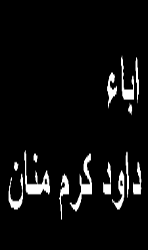

(250, 148)

In [173]:
print(labels[0])
cv2_imshow(image_list[0])
image_list[0].shape

In [174]:
img = image_list[0]
i = img.shape[0]
j = img.shape[1]
#cv2_imshow(img[int(i/2):, :j-1])

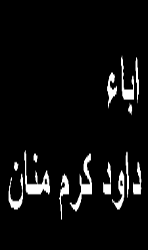

In [175]:
cv2_imshow(img)

In [176]:
f_n = img[:int(i/2)-1, :j-1]
l_n = img[int(i/2):, :j-1]

In [177]:
f_n.shape

(124, 147)

## Investigating a way of splitting (first-last) names

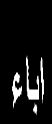

In [178]:
# first - name extraction
f_n = f_n[:, 95:]
cv2_imshow(f_n)

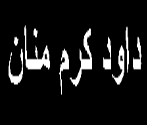

In [179]:
# last - name extraction
cv2_imshow(l_n)

## the most important step is here: to extract the vertical projection profile of our image of the name so as to detect the white spaces between  words for separation (just a step in the way :)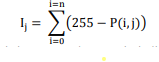
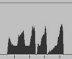

In [12]:
# apply the vertical projection profile here.
def apply_vertical_proj_prof(img):
  vertical_pixel_sum = np.sum(img, axis=0)
  myprojection = vertical_pixel_sum / 255

  blankImage = np.zeros_like(img)  
  for i, value in enumerate(myprojection):
    cv2.line(blankImage, (i, 0), (i, img.shape[0]-int(value)), (255, 255, 255), 1)

  cv2_imshow(blankImage)

  return blankImage
  # cv2.waitKey(0)
  

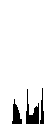

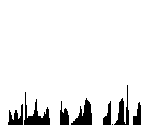

In [180]:
f_n_proj = apply_vertical_proj_prof(f_n)
l_n_proj = apply_vertical_proj_prof(l_n)

In [181]:
stream_proj = l_n_proj[-1:, :]

In [182]:
stream_proj.shape

(1, 147)

In [183]:
cv2_imshow(stream_proj)

In [184]:
stream_proj_lst = l_n_proj[-1:, :][0].tolist()

In [185]:
stream_proj_lst

[255,
 255,
 255,
 255,
 255,
 255,
 255,
 255,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 255,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 255,
 255,
 255,
 255,
 255,
 255,
 255,
 255,
 255,
 255,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 255,
 255,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 255,
 255,
 255,
 255,
 255,
 255,
 255,
 255,
 255,
 255,
 255,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 255,
 0,
 255,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 255,
 255,
 255,
 255,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 255,
 255,
 255,
 255,
 255,
 255]

## we try to detect the indices of white spaces between words

In [13]:
# extract the indices and length of white spaces in our sentence

def get_white_spaces_idx(stream_v_proj):
   lst_spaces = list()
   temp_lst = list() 

   for i in range(len(stream_v_proj)):
      if stream_v_proj[i]==255:
        if len(temp_lst)==0:
          temp_lst.append(i)    # start point index of white space
      elif stream_v_proj[i]==0:
        if len(temp_lst)!=0:
           temp_lst.append(i)   # end point index of white space
           space_length = temp_lst[1] - temp_lst[0]
           lst_spaces.append((temp_lst[0], temp_lst[1], space_length))
           temp_lst = []

   if len(temp_lst)!=0:
       temp_lst.append(len(stream_v_proj))
       space_length = temp_lst[1] - temp_lst[0]
       lst_spaces.append((temp_lst[0], temp_lst[1], space_length))
       temp_lst = []

   return lst_spaces   

In [187]:
space_interest = get_white_spaces_idx(stream_proj_lst)
space_interest

[(0, 8, 8),
 (23, 24, 1),
 (50, 60, 10),
 (69, 71, 2),
 (92, 103, 11),
 (111, 112, 1),
 (113, 114, 1),
 (129, 133, 4),
 (141, 147, 6)]

## A try to crop our words (segments) after detectionof white spaces

In [7]:
def get_all_segmented_words(n, bag_spaces):
    lst_segmented_words = list()
    img_word = ''

    for i in range(len(bag_spaces)):
        start_ = bag_spaces[i][1]
        if i+1 < len(bag_spaces):
           end_ = bag_spaces[i+1][0]
           img_word = n[:, start_:end_]
        else:
              break
        if img_word.shape[1]<3:
          continue       
        lst_segmented_words.append(img_word)

    return lst_segmented_words    


In [188]:
imgg_words = get_all_segmented_words(l_n, space_interest)

## an example image to evaluate our word segmentation function

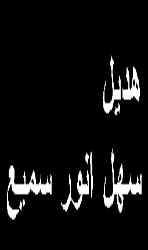

In [135]:
example = image_list[4999]
cv2_imshow(example)

In [85]:
# get the name segmented: as the following:
def segment_into_slices(img_name):
    i = img_name.shape[0]
    j = img_name.shape[1]

    f_n = img_name[:int(i/2)-1, :j-1]
    f_n = f_n[:, 85:]
    # cv2_imshow(f_n)
    l_n = img_name[int(i/2):, :j-1]
    print('\n')
    # cv2_imshow(l_n)

    # get the projection profile for both (f_n, l_n)
    f_n_proj = apply_vertical_proj_prof(f_n)
    l_n_proj = apply_vertical_proj_prof(l_n)

    # detect the white spaces in the words for segmentation
    stream_proj_lst_f_n = f_n_proj[-1:, :][0].tolist()
    # print(stream_proj_lst_f_n)
    stream_proj_lst_l_n = l_n_proj[-1:, :][0].tolist()

    # detect the white space range in details: (start_idx, end_idx, length)

    space_interest_f_n = get_white_spaces_idx(stream_proj_lst_f_n)
    print(space_interest_f_n)
    space_interest_l_n = get_white_spaces_idx(stream_proj_lst_l_n)
    
    # crop your slices!
    lst_f_n_slices = get_all_segmented_words(f_n, space_interest_f_n)
    lst_l_n_slices = get_all_segmented_words(l_n, space_interest_l_n)

    return lst_f_n_slices, lst_l_n_slices

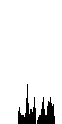

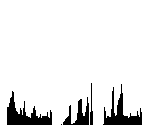

[(0, 18, 18), (36, 37, 1), (55, 62, 7)]


In [136]:
lst_f_n_slices, lst_l_n_slices = segment_into_slices(example)
# segment_into_slices(example)

In [87]:
# visualize our results
def visualize_name_slices(img_name, lst_f_n_slices, lst_l_n_slices):
  print('Whole-name:')
  cv2_imshow(img_name)
  print('\n')

  print('First-name-slices:')
  for i in lst_f_n_slices:
    cv2_imshow(i)
  print('\n')  
  
  print('Last-name-slices:')
  for i in lst_l_n_slices:
    cv2_imshow(i)
  print('\n')  

## You can see here that we could get the initial segments of our name (for both first and last) names

Whole-name:


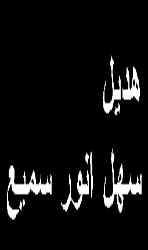



First-name-slices:




Last-name-slices:


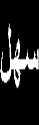

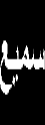

In [169]:
visualize_name_slices(example, reversed(lst_f_n_slices), reversed(lst_l_n_slices))

##Split each segmented slice of the word into it's character building-block to be used in a further analysis: consider this segment as an example

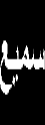

In [153]:
example2 = lst_l_n_slices[0]
cv2_imshow(example2)

In [91]:
def navigate_image(img_proj):
  lst_black_pixels_count = list()
  for c in range(img_proj.shape[1]):
    count_ = np.histogram(img_proj[:, c])[0][0]
    lst_black_pixels_count.append(count_)
    
  return lst_black_pixels_count  

In [92]:
def get_lst_indices(lst_black_pixels_count):

  second_peak_black_pixel_count = np.unique(np.array(lst_black_pixels_count))[-3] # the second highest column
  print(second_peak_black_pixel_count)

  # select indices of columns that match or exceed that second column number of black pixels.
  indices_splitting = np.where(np.array(lst_black_pixels_count)>second_peak_black_pixel_count)[0]
  print(indices_splitting)
  
  return indices_splitting

In [190]:
# def refine_segmentation(lst_segmented_characters):
  


In [93]:
def segment_for_each_character(segment_img):
  print(segment_img.shape)
  cv2_imshow(segment_img)
  lst_segmented_characters = list()
  segment_img_proj = apply_vertical_proj_prof(segment_img)

  # count the black pixels in the vertical projection profile for this segmented slice.
  lst_black_pixels_count = navigate_image(segment_img_proj)
  print(sorted(lst_black_pixels_count), len(lst_black_pixels_count))
  lst_splitting_indices = get_lst_indices(lst_black_pixels_count)
  print(lst_splitting_indices)

  start_ = 0
  for i in lst_splitting_indices:
    end_ = i
    slice_ = segment_img[:, start_+1:end_+4]
    lst_segmented_characters.append(slice_)
    print(start_, end_, 'HII')
    start_ = end_
  
  slice_ = segment_img[:, start_:] # the last slice
  lst_segmented_characters.append(slice_)             
        
  

  return lst_segmented_characters

  # # except Exception as e:
  # #    print('Error') 

  

(125, 45)


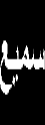

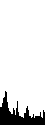

[7, 7, 7, 7, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 11, 11, 11, 12, 12, 13, 13, 13, 13, 14, 15, 15, 15, 17, 17, 17, 17, 18, 18, 19, 22, 23, 24, 27, 28, 33, 34] 45
28
[5 6]
[5 6]
0 5 HII
5 6 HII


In [154]:
lst_segmented_characters = segment_for_each_character(example2)

## this is an initial output just for evalution

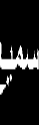

In [155]:
for i in lst_segmented_characters:
  cv2_imshow(i)
  print('\n')

In [144]:
slice_1 = lst_segmented_characters[0]
slice_2 = lst_segmented_characters[1]
slice_3 = lst_segmented_characters[2]

In [145]:
slice_1.shape, slice_2.shape, slice_3.shape,

((125, 20), (125, 4), (125, 7))

In [ ]:
n = np.array([1, 2, 3])

In [ ]:
n[-2]

2

## it's a try to apply the character segmentation iteratively on our word to try detecting single characters as possible!

In [216]:
def decide_if_to_segment(segment_image):
  cpy_segment_image = segment_image
  lst_final_segments = list()
 
  while True:
   need_segmentation = False 
   lst_segmented_characters = segment_for_each_character(cpy_segment_image) 
   for i in range(len(lst_segmented_characters)):
     slice_ = lst_segmented_characters[i]
     if slice_.shape[1] in range(7, 15): # if the segmented slice no of columns is within this range --> it's a character.
       lst_final_segments.append(slice_)
     elif slice_.shape[1] < 7:
       continue
     else:
       cpy_segment_image = slice_
       need_segmentation=True
       break
   if not(need_segmentation):
     break    

  
  return lst_final_segments 


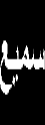

In [217]:
cv2_imshow(example2)

(125, 45)


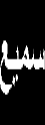

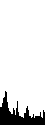

[7, 7, 7, 7, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 11, 11, 11, 12, 12, 13, 13, 13, 13, 14, 15, 15, 15, 17, 17, 17, 17, 18, 18, 19, 22, 23, 24, 27, 28, 33, 34] 45
28
[5 6]
[5 6]
0 5 HII
5 6 HII
(125, 39)


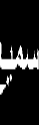

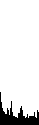

[7, 7, 7, 7, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 11, 11, 11, 12, 12, 13, 13, 13, 13, 14, 15, 15, 15, 17, 17, 17, 17, 19, 23, 24, 33] 39
23
[ 0 11]
[ 0 11]
0 0 HII
0 11 HII
(125, 28)


[7, 7, 7, 7, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 11, 12, 12, 13, 13, 13, 15, 15, 17, 19, 24] 28
17
[ 0 10]
[ 0 10]
0 0 HII
0 10 HII
(125, 18)


[7, 7, 7, 8, 8, 9, 9, 9, 9, 9, 9, 9, 11, 13, 13, 15, 15, 19] 18
13
[ 0  1 16]
[ 0  1 16]
0 0 HII
0 1 HII
1 16 HII
(125, 16)


[7, 7, 7, 8, 8, 9, 9, 9, 9, 9, 9, 9, 11, 13, 13, 15] 16
11
[11 14 15]
[11 14 15]
0 11 HII
11 14 HII
14 15 HII


In [218]:
lst_final_segments = decide_if_to_segment(example2)

## Here the output is good for this segment word.
## it still need more enhancement

In [219]:
for i in reversed(lst_final_segments):
  cv2_imshow(i)
  print(i.shape)

(125, 14)


(125, 13)


(125, 14)


(125, 8)


In [168]:
# for i in range(len(image_list)):
#   cv2.imwrite('/content/generated_images/img_{%d}.jpg'%(i+1) , image_list[i])

In [196]:
# import glob
# for name in glob.glob('/content/generated_images/img_*.jpg'):
#     print(name)

## Consider here another evalution example

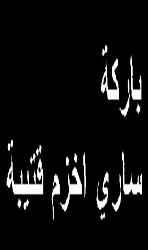

In [220]:
cv2_imshow(image_list[666])

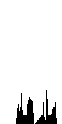

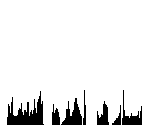

[(0, 16, 16), (34, 35, 1), (57, 62, 5)]


In [221]:
example3 = image_list[666]
lst_f_n_slices3, lst_l_n_slices3 = segment_into_slices(example3)
# segment_into_slices(example)

Whole-name:


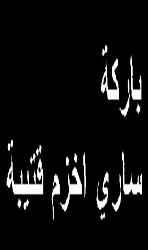



First-name-slices:




Last-name-slices:


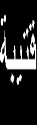

In [222]:
visualize_name_slices(example3, reversed(lst_f_n_slices3), reversed(lst_l_n_slices3))

In [225]:
seg = lst_f_n_slices3[0]
lst_segmented_characters3 = decide_if_to_segment(seg)

(124, 18)


[6, 9, 9, 9, 9, 11, 13, 14, 16, 17, 20, 20, 23, 24, 24, 25, 27, 31] 18
25
[ 5 13]
[ 5 13]
0 5 HII
5 13 HII


In [226]:
for i in lst_segmented_characters3:
  cv2_imshow(i)

## We could reach a great advance in the task of segmentation for arabic characters segmentation but, still there is a room for more adjustment for more better results, if possible ! 